In [180]:
# Importing all of the required packages

import numpy as np
import tensorflow as tf
import keras
import scipy.io.matlab as mat
import os
import os.path as path
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics 

if os.path.exists('pretrained_model.h5'):
    os.remove('pretrained_model.h5')
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [163]:
# Optional Downsampling Feature so that GPU does not burn down
def downsampler(value, factor):
    return value[::factor]

# Cleans up the data by removing the trash starting machine data sample points
def snipper(value):
    x = len(value)
    r = x % int(np.floor((x/10000))*10000)
    value = value[r:]
    return value

def extractor(dataframe):
    y = dataframe['label']
    x = dataframe.drop('label', axis=1)
    return x, y 

def asinput(dataframe):
    return np.reshape(np.array(dataframe), (len(np.array(dataframe)),-1,1))

In [164]:
# This block is for a 10 class fault classifier for the CWRU dataset. Characteristics are that it was sampled at 12000 Hz

# Variables below are lists which help extract data from the .mat files stored in the folders
cwru_10_classes = ['N','B7','B14','B21','IR7','IR14','IR21','OR7','OR14','OR21']
cwru_4_classes = ['N', 'B', 'IR', 'OR']
pull_files = ['12K', 'N']

# Change this for whichever implementation
cwru_classes = cwru_10_classes
cwru_classes_tf = cwru_4_classes
# Some list and dictionary and list comprehension to get the data loaded into
cwru_files = [path.join(root, name) for root, dirs, files in os.walk('cwru') for name in files]
cwru_12k_files = [file for file in cwru_files for name in pull_files if name in file ]
cwru_data = {clss : [values for file in cwru_12k_files if clss in file for key, values in mat.loadmat(file).items() if 'DE' in key] for clss in cwru_classes}
cwru_data_tf = {clss : [values for file in cwru_12k_files if clss in file for key, values in mat.loadmat(file).items() if 'DE' in key] for clss in cwru_classes_tf}         

In [165]:
# This block is for the triaxial bearing vibration dataset. Sample Rate: 10000 Hz

triaxial_classes = ['Healthy', 'Inner', 'Outer']

triaxial_files = [path.join(root, name) for root, dirs, files in os.walk('triaxial') for name in files]
triaxial_data = {clss : [np.array(pd.read_csv(file)[' X-axis']) for file in triaxial_files if clss in file] for clss in triaxial_classes}


In [166]:
# This block is for the mafaulda vibration dataset. Sample Rate 50000 hz

mfd_classes = ['normal', 'ball', 'cage', 'outer']

mfd_files = [path.join(root, name) for root, dirs, files in os.walk('mfd') for name in files]
mfd_data = {clss : [np.array(pd.read_csv(file).iloc[:, 1]) for file in mfd_files if clss in file] for clss in mfd_classes}

In [177]:
# Waow so smart. Change this to change the dataset
data = mfd_data
classes = mfd_classes

# Reduce sampling rate accordingly
sample_rate = 50000

# Optional Downsampling Feature, factor 1 for orignal 
data = {key : [downsampler(value, 5) for value in values] for key, values in data.items()} 

# Some necessary variables and ancillaries
minmax = MinMaxScaler(feature_range=(-1,1))
window_size = int(sample_rate/10)
stride = int(window_size/2)

data = {key : [snipper(value) for value in values] for key, values in data.items() for value in values}

data = {key : [minmax.fit_transform(np.reshape(value, (-1,1))) for value in values] for key, values in data.items()} 

data = {key : [[value[i:i + window_size] for i in range(0, len(value) - window_size + 1, stride)] for value in values] for key, values in data.items()} 

data = {key : np.squeeze([leaf for tree in data[key] for leaf in tree]) for key in data}

dfs = []
for key, values in data.items():
    tdf = pd.DataFrame(values)
    tdf['label'] = key
    dfs.append(tdf)

df = pd.concat(dfs, ignore_index=True)

traindf, testdf = train_test_split(df, test_size=0.2, random_state=0, shuffle=True)

xtrain, ytrain = extractor(traindf)
xtest, ytest = extractor(testdf)

ytest = pd.get_dummies(ytest)
ytrain = pd.get_dummies(ytrain)

xtrain = asinput(xtrain)
ytrain = np.squeeze(asinput(ytrain.astype(int)))

xtest = asinput(xtest)
ytest = np.squeeze(asinput(ytest.astype(int)))

In [178]:
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=(window_size,1)))

model.add(keras.layers.Conv1D(filters=128, kernel_size=9, activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))

model.add(keras.layers.Conv1D(filters=64, kernel_size=9, activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))

model.add(keras.layers.Conv1D(filters=32, kernel_size=9, activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(len(classes)))
model.add(keras.layers.Softmax())

    
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_42 (Conv1D)          (None, 4992, 128)         1280      
                                                                 
 max_pooling1d_42 (MaxPoolin  (None, 2496, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_43 (Conv1D)          (None, 2488, 64)          73792     
                                                                 
 max_pooling1d_43 (MaxPoolin  (None, 1244, 64)         0         
 g1D)                                                            
                                                                 
 conv1d_44 (Conv1D)          (None, 1236, 32)          18464     
                                                                 
 max_pooling1d_44 (MaxPoolin  (None, 618, 32)        

In [179]:
history = model.fit(xtrain, ytrain, epochs=20, batch_size=16, validation_split=0.2)
_, validation_accuracy = model.evaluate(xtest, ytest, verbose=0)

Epoch 1/20
149/149 [==============================] - 5s 28ms/step - loss: 1.2653 - accuracy: 0.3580 - val_loss: 1.0462 - val_accuracy: 0.4732
Epoch 2/20
149/149 [==============================] - 4s 26ms/step - loss: 0.9943 - accuracy: 0.5141 - val_loss: 0.8614 - val_accuracy: 0.6174
Epoch 3/20
149/149 [==============================] - 4s 26ms/step - loss: 0.8479 - accuracy: 0.5984 - val_loss: 0.7108 - val_accuracy: 0.6879
Epoch 4/20
149/149 [==============================] - 4s 26ms/step - loss: 0.6558 - accuracy: 0.7079 - val_loss: 0.6255 - val_accuracy: 0.7315
Epoch 5/20
149/149 [==============================] - 4s 26ms/step - loss: 0.5108 - accuracy: 0.7776 - val_loss: 0.3711 - val_accuracy: 0.8456
Epoch 6/20
149/149 [==============================] - 4s 26ms/step - loss: 0.3871 - accuracy: 0.8540 - val_loss: 0.2691 - val_accuracy: 0.9161
Epoch 7/20
149/149 [==============================] - 4s 26ms/step - loss: 0.3260 - accuracy: 0.8720 - val_loss: 0.3364 - val_accuracy: 0.8943

In [181]:
print(validation_accuracy*100)

# Saving the pretrained model
model.save('pretrained_model.h5')

96.77852392196655


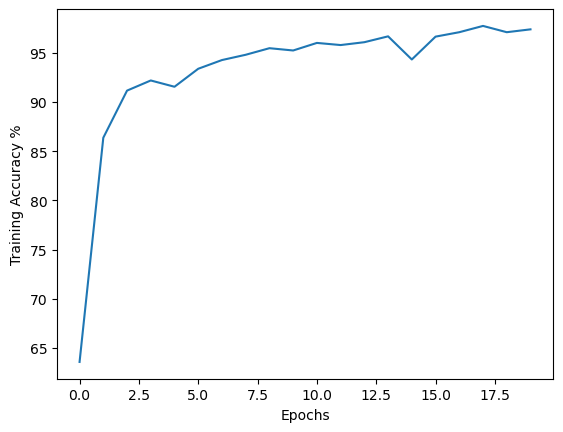

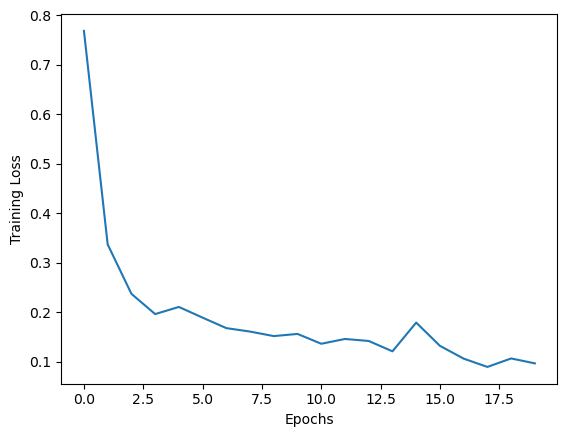

<Figure size 640x480 with 0 Axes>

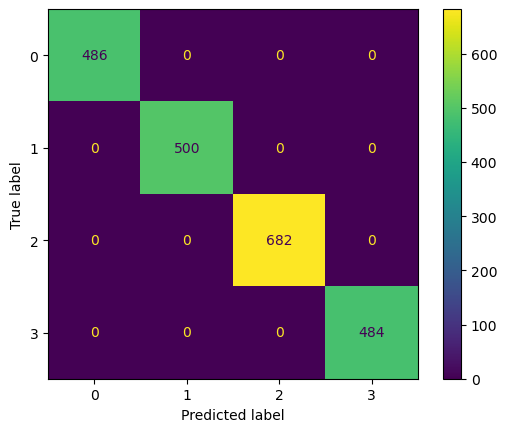

In [171]:
# Block of code to review performance nothing else

plt.figure(0)
plt.plot(np.multiply(history.history['accuracy'],100))
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy %')

plt.figure(1)
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

predictions = np.argmax(model.predict(xtest, verbose=0), axis=1)
confmat = metrics.confusion_matrix(np.argmax(ytest,axis=1), predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confmat)

plt.figure(2)
cm_display.plot()
plt.show()

In [172]:
# Waow so smart. Change this to change the dataset
data = cwru_data_tf
classes = cwru_classes_tf

# Reduce sampling rate accordingly
sample_rate = 12000

# data = {key : [downsampler(value, 5) for value in values] for key, values in data.items()} 

# Some necessary variables and ancillaries
minmax = MinMaxScaler(feature_range=(-1,1))
window_size = int(sample_rate/10)
stride = int(window_size/2)

data = {key : [snipper(value) for value in values] for key, values in data.items() for value in values}

data = {key : [minmax.fit_transform(np.reshape(value, (-1,1))) for value in values] for key, values in data.items()} 

data = {key : [[value[i:i + window_size] for i in range(0, len(value) - window_size + 1, stride)] for value in values] for key, values in data.items()} 

data = {key : np.squeeze([leaf for tree in data[key] for leaf in tree]) for key in data}

dfs = []
for key, values in data.items():
    tdf = pd.DataFrame(values)
    tdf['label'] = key
    dfs.append(tdf)

df = pd.concat(dfs, ignore_index=True)

traindf, testdf = train_test_split(df, test_size=0.2, random_state=0, shuffle=True)

xtrain, ytrain = extractor(traindf)
xtest, ytest = extractor(testdf)

ytest = pd.get_dummies(ytest)
ytrain = pd.get_dummies(ytrain)

xtrain = asinput(xtrain)
ytrain = np.squeeze(asinput(ytrain.astype(int)))

xtest = asinput(xtest)
ytest = np.squeeze(asinput(ytest.astype(int)))

In [173]:
# Somehow trying to implement transfer learning

# Loading and chopping the head off
headless_model = keras.models.load_model('pretrained_model.h5')

transfer_model = keras.models.Sequential()

transfer_model.add(keras.Input(shape=(window_size,1)))

for layer in headless_model.layers[:-7]:
    layer.trainable = False
    transfer_model.add(layer)

for layer in transfer_model.layers[-2:]:
    layer.trainable = True

transfer_model.add(keras.layers.Flatten())

transfer_model.add(keras.layers.Dense(32, activation='relu'))
transfer_model.add(keras.layers.Dropout(0.4))

transfer_model.add(keras.layers.Dense(16, activation='relu'))
transfer_model.add(keras.layers.Dropout(0.2))

transfer_model.add(keras.layers.Dense(len(classes)))
transfer_model.add(keras.layers.Softmax())

opt = keras.optimizers.Adam(learning_rate=0.001)
transfer_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

transfer_model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_39 (Conv1D)          (None, 1192, 128)         1280      
                                                                 
 max_pooling1d_39 (MaxPoolin  (None, 596, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_40 (Conv1D)          (None, 588, 64)           73792     
                                                                 
 max_pooling1d_40 (MaxPoolin  (None, 294, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_41 (Conv1D)          (None, 286, 32)           18464     
                                                                 
 max_pooling1d_41 (MaxPoolin  (None, 143, 32)        

In [174]:
history = transfer_model.fit(xtrain, ytrain, epochs=20, batch_size=16, validation_split=0.2)
_, validation_accuracy = transfer_model.evaluate(xtest, ytest, verbose=0)

Epoch 1/20
431/431 [==============================] - 4s 8ms/step - loss: 0.1424 - accuracy: 0.9496 - val_loss: 9.3920e-04 - val_accuracy: 1.0000
Epoch 2/20
431/431 [==============================] - 3s 8ms/step - loss: 0.0348 - accuracy: 0.9879 - val_loss: 8.5395e-05 - val_accuracy: 1.0000
Epoch 3/20
431/431 [==============================] - 3s 7ms/step - loss: 0.0250 - accuracy: 0.9916 - val_loss: 2.1151e-05 - val_accuracy: 1.0000
Epoch 4/20
431/431 [==============================] - 3s 7ms/step - loss: 0.0156 - accuracy: 0.9945 - val_loss: 4.1222e-06 - val_accuracy: 1.0000
Epoch 5/20
431/431 [==============================] - 3s 7ms/step - loss: 0.0096 - accuracy: 0.9964 - val_loss: 0.0017 - val_accuracy: 0.9994
Epoch 6/20
431/431 [==============================] - 3s 7ms/step - loss: 0.0125 - accuracy: 0.9962 - val_loss: 6.2291e-05 - val_accuracy: 1.0000
Epoch 7/20
431/431 [==============================] - 3s 7ms/step - loss: 0.0128 - accuracy: 0.9962 - val_loss: 5.1930e-06 - val

100.0


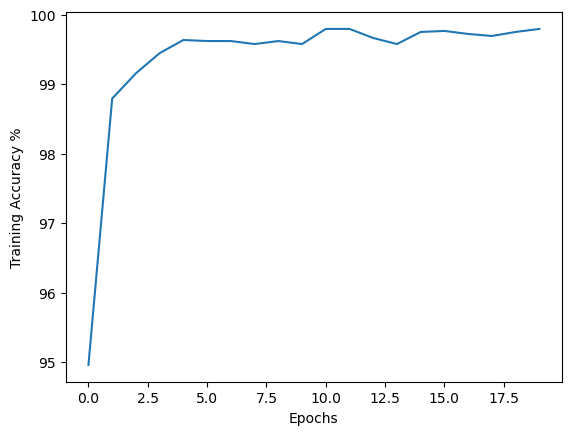

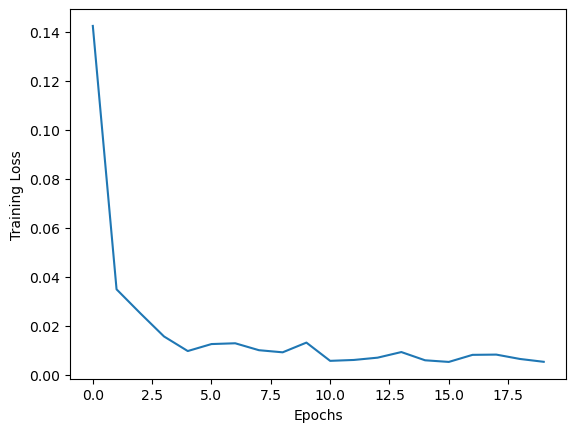

<Figure size 640x480 with 0 Axes>

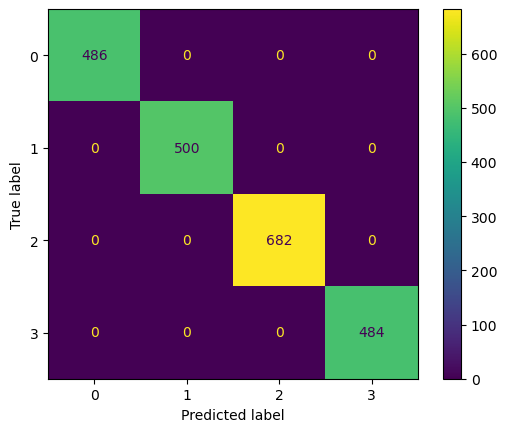

In [175]:
# Block of code to review performance nothing else
print(validation_accuracy*100)

plt.figure(0)
plt.plot(np.multiply(history.history['accuracy'],100))
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy %')

plt.figure(1)
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

predictions = np.argmax(transfer_model.predict(xtest, verbose=0), axis=1)
confmat = metrics.confusion_matrix(np.argmax(ytest,axis=1), predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confmat)

plt.figure(2)
cm_display.plot()
plt.show()